# Card Classification

Dataset bertujuan untuk klasifikasi 53 kartu remi

## Load data and initial config

In [18]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import cv2
from skimage.feature import hog, local_binary_pattern

In [19]:
train_data_dir = './train/'
test_data_dir = './test/'
valid_data_dir = './valid/'
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(tr_dir, val_dir, ts_dir):
    # train dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)
    # valid dataframe
    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)
    # test dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

train_df, valid_df, test_df = create_df(train_data_dir, valid_data_dir, test_data_dir)

## EDA (Exploratory Data Analysis)

In [20]:
def plot_label_count (df, column, xaxis_label, yaxis_label, plot_title):
    vcounts=df[column].value_counts()
    labels=vcounts.keys().tolist()
    values=vcounts.tolist()
    lcount=len(labels)
    if lcount>53:
        print('The number of labels is >53, no plot will be produced')
    else:
        width=lcount * 4
        width=np.min([width, 20])
        plt.figure(figsize=(width,5))
        form = {'family': 'serif', 'color': 'blue', 'size': 25}
        plt.bar(labels, values)
        plt.title(plot_title, fontsize= 24, color='blue')
        plt.xticks(rotation=90, fontsize=18)
        plt.yticks(fontsize=18)
        plt.xlabel(xaxis_label, fontdict=form)
        plt.ylabel(yaxis_label, fontdict=form)
        plt.show()

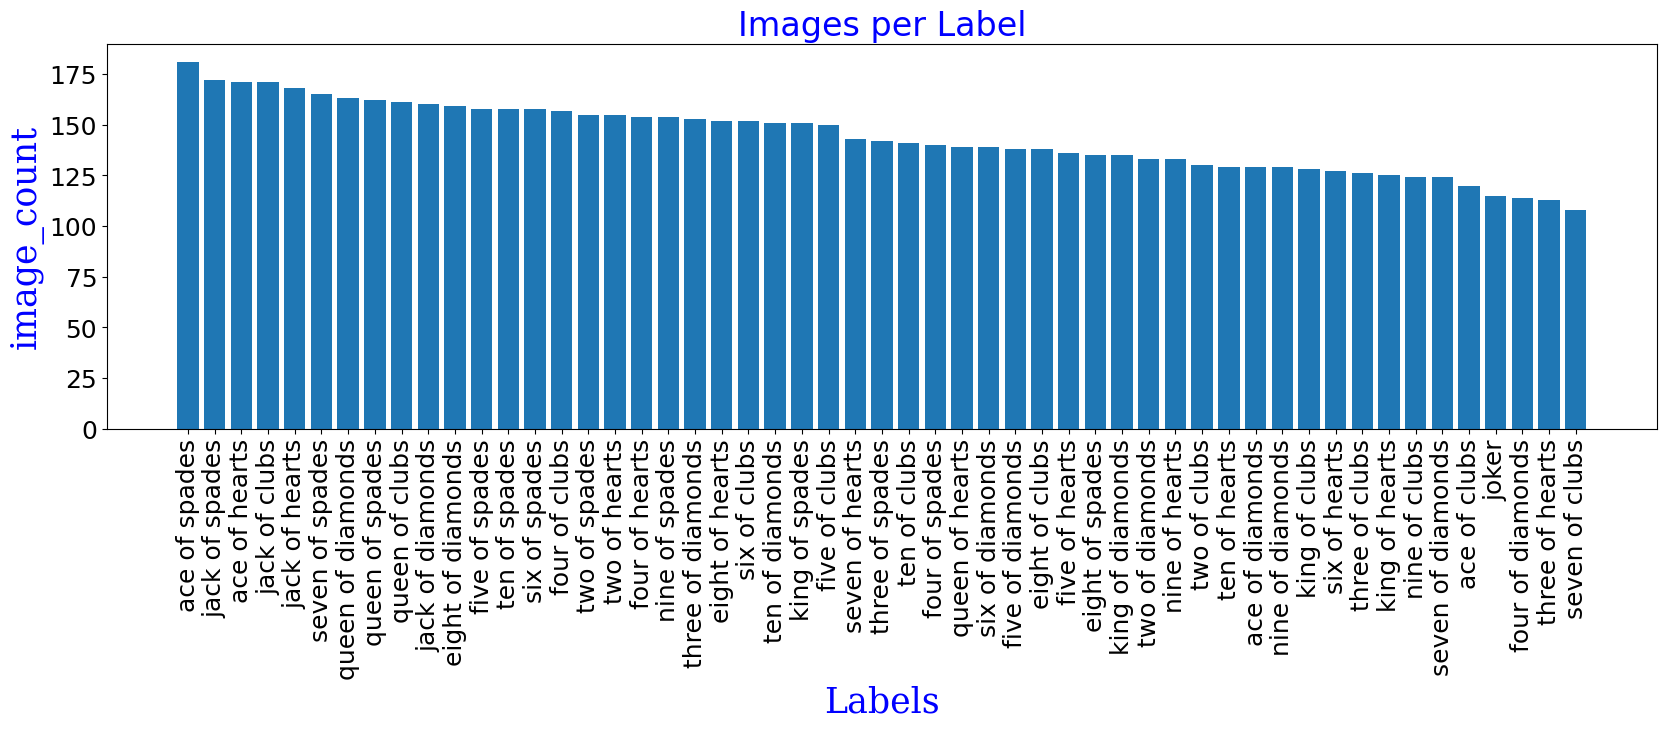

In [21]:
xaxis_label='Labels'
yaxis_label= 'image_count'
plot_title='Images per Label'
plot_label_count (train_df, 'labels', xaxis_label, yaxis_label, plot_title)

In [22]:
cv2.imread('/content/test/five of clubs/1.jpg')

## Preprocessing Data

In [23]:
# def reduce_noise_each_image(df):
#   df=df.copy()
#   for i in range(len(df)):
#     img=cv2.imread(df['filepaths'][i])
#     img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
#     img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
#     img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
#     cv2.imwrite(df['filepaths'][i], img_output)
#   return df

#   train_df=reduce_noise_each_image(train_df)
#   valid_df=reduce_noise_each_image(valid_df)
#   test_df=reduce_noise_each_image(test_df)

In [24]:
# def preprocess_canny(df):
#   df=df.copy()
#   for i in range(len(df)):
#     img=cv2.imread(df['filepaths'][i])
#     edges = cv2.Canny(img,100,200)
#     cv2.imwrite(df['filepaths'][i], edges)
#   return df

# train_df=preprocess_canny(train_df)
# valid_df=preprocess_canny(valid_df)
# test_df=preprocess_canny(test_df)


## LBP Feature Extraction

In [25]:
def lbp_histogram_spatial(image, P=8, R=1, grid_size=(4, 4), n_bins=256, method="uniform"):
    # Convert image to grayscale if it isn't already
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Get the dimensions for the grid
    height, width = image.shape
    grid_height, grid_width = height // grid_size[0], width // grid_size[1]

    # Placeholder for concatenated histograms
    histograms = []

    # Loop through each cell in the grid
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            # Define cell region
            cell = image[i * grid_height:(i + 1) * grid_height, j * grid_width:(j + 1) * grid_width]

            # Compute LBP for the cell
            lbp = local_binary_pattern(cell, P, R, method=method)

            # Calculate histogram for the cell and normalize
            hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_bins + 1), range=(0, n_bins))
            hist = hist / hist.sum()  # Normalize

            # Append histogram to the list
            histograms.append(hist)

    # Concatenate all histograms into a single feature vector
    feature_vector = np.concatenate(histograms)
    return feature_vector

In [26]:
def hu_moments(image):
    # Convert image to grayscale if it isn't already
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate Hu Moments
    moments = cv2.moments(image)
    hu_moments = cv2.HuMoments(moments)
    hu_moments = hu_moments.flatten()

    return hu_moments

In [27]:
sample_1 = cv2.imread(train_df['filepaths'][0])
sample_1 = cv2.cvtColor(sample_1, cv2.COLOR_BGR2GRAY)
hu_moment = hu_moments(sample_1)

In [28]:
R = 1
P = 8
grid_size = (2, 2)
n_bins = P*2 + 2

In [29]:
import tqdm
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern

X_train = []
y_train = []
for i in tqdm.tqdm(range(len(train_df))):
    image_path = train_df['filepaths'][i]
    image = cv2.imread(image_path)
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # use lbp method
    lbp = lbp_histogram_spatial(image, P, R, grid_size, n_bins)
    # append hu moments
    lbp = np.append(lbp, hu_moments(image))
    X_train.append(lbp)
    y_train.append(train_df['labels'][i])
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 7624/7624 [01:44<00:00, 73.17it/s] 


In [30]:
print(X_train.shape)
print(y_train.shape)

(7624, 79)
(7624,)


In [31]:
X_valid = []
y_valid = []
for i in tqdm.tqdm(range(len(valid_df))):
    image_path = valid_df['filepaths'][i]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # use lbp method
    lbp = lbp_histogram_spatial(image, P, R, grid_size, n_bins)
    # append hu moments
    lbp = np.append(lbp, hu_moments(image))
    X_valid.append(lbp)
    y_valid.append(valid_df['labels'][i])
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

100%|██████████| 265/265 [00:02<00:00, 89.97it/s]


In [32]:
print(X_valid.shape)
print(y_valid.shape)

(265, 79)
(265,)


In [34]:
X_test = []
y_test = []
for i in tqdm.tqdm(range(len(test_df))):
    image_path = test_df['filepaths'][i]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # use lbp method
    lbp = lbp_histogram_spatial(image, P, R, grid_size, n_bins)
    # append hu moments
    lbp = np.append(lbp, hu_moments(image))
    X_test.append(lbp)
    y_test.append(test_df['labels'][i])
X_test = np.array(X_test)
y_test = np.array(y_test)

100%|██████████| 265/265 [00:03<00:00, 74.22it/s]


In [35]:
print(X_test.shape)
print(y_test.shape)

(265, 79)
(265,)


[ 2.47130102e-02  2.67059949e-02  2.39158163e-03  4.46428571e-03
  1.67410714e-03  3.50765306e-03  2.39158163e-03  1.43494898e-03
  8.86559311e-01  4.61575255e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.26753827e-02  1.09215561e-02
  8.76913265e-04  1.91326531e-03  3.98596939e-04  1.51466837e-03
  7.17474490e-04  5.58035714e-04  9.42920918e-01  2.75031888e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.22767857e-02  1.29942602e-02  1.35522959e-03  2.79017857e-03
  1.03635204e-03  2.15242347e-03  3.98596939e-04  1.59438776e-04
  9.39492985e-01  2.73437500e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.17633929e-02  2.18431122e-02
  1.27551020e-03  5.18176020e-03  1.51466837e-03  3.98596939e-03
  1.19579082e-03  7.97193

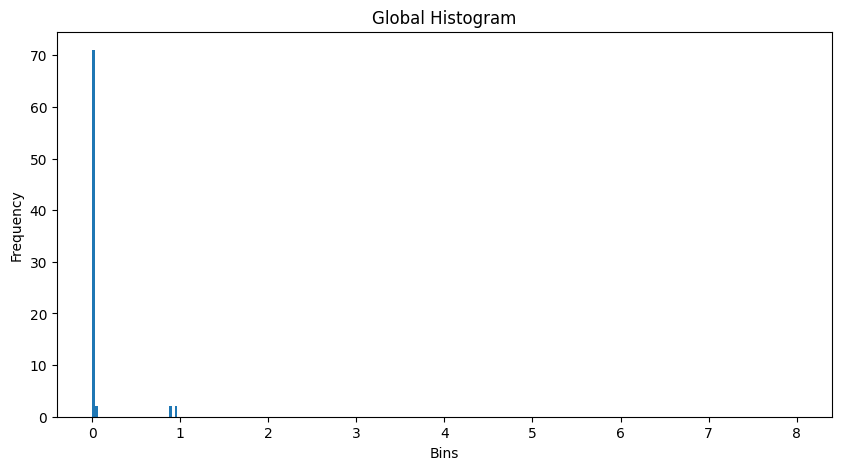

In [36]:
sample = X_test[1]
print(sample)

# show bar chart
plt.figure(figsize=(10, 5))
plt.hist(sample.ravel(), bins=256, range=(0, 8))
plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.title('Global Histogram')
plt.show()

## Training Random Forest LBP

In [37]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'random_state': 123,
}

rf = RandomForestClassifier(**rf_params)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
test_acc_rf = np.mean(y_pred_rf == y_test)
print(f"Random Forest Accuracy: {test_acc_rf * 100:.2f}%")

Random Forest Accuracy: 18.11%


In [38]:
# convert class to 0...
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_valid = le.transform(y_valid)
y_test = le.transform(y_test)

In [39]:
from xgboost import XGBClassifier

xgb_params = {
    'objective': 'multi:softmax',
    'num_class': len(np.unique(y_train)),
    'seed': 123,
    'n_estimators': 200,
}

xgb = XGBClassifier(**xgb_params)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
test_acc_xgb = np.mean(y_pred_xgb == y_test)
print(f"XGBoost Accuracy: {test_acc_xgb * 100:.2f}%")

XGBoost Accuracy: 20.38%


## Training AUTOML Model

In [45]:
classes, counts = np.unique(y_train, return_counts=True)
print("Classes:", classes)
print("Counts per class:", counts)

Classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52]
Counts per class: [120 129 171 181 138 159 152 135 150 138 136 158 157 114 154 140 171 160
 168 172 115 128 135 125 151 124 129 133 154 161 163 139 162 108 124 143
 165 152 139 127 158 141 151 129 158 126 153 113 142 130 133 155 155]


In [42]:
# convert class to 0...
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_valid = le.transform(y_valid)
y_test = le.transform(y_test)

In [46]:
from tpot import TPOTClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut

# xgboost_config = {
#     'xgboost.XGBClassifier': {
#         'learning_rate': [0.01, 0.1, 0.2, 0.3],
#         'n_estimators': [50, 100, 200, 300],
#         'max_depth': [3, 5, 7, 9],
#         'min_child_weight': [1, 3, 5],
#         'subsample': [0.6, 0.8, 1.0],
#         'colsample_bytree': [0.6, 0.8, 1.0],
#         'gamma': [0, 0.1, 0.2, 0.3],
#         'scale_pos_weight': [1, 2, 3],
#         'reg_alpha': [0, 0.1, 0.5, 1],
#         'reg_lambda': [0.5, 1, 1.5],
#     }
# }

# # Create a TPOTClassifier instance
# tpot = TPOTClassifier(
#     generations=5,  # Number of iterations for optimization
#     population_size=20,  # Number of pipelines per generation
#     verbosity=2,  # Level of logging verbosity
#     config_dict=xgboost_config,  # Use the custom config for XGBoost
#     random_state=42,
#     n_jobs=-1  # Use all available cores
# )

rf_config = {
    'sklearn.ensemble.RandomForestClassifier': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }
}

# Create a TPOTClassifier instance
tpot = TPOTClassifier(
    generations=5,  # Number of iterations for optimization
    population_size=20,  # Number of pipelines per generation
    verbosity=2,  # Level of logging verbosity
    config_dict=rf_config,  # Use the custom config for Random Forest
    random_state=42,
    n_jobs=-1  # Use all available cores
)

tpot.fit(X_train, y_train)

print(tpot.score(X_test, y_test))

is_classifier


d:\Tugazz\Coolyeah\PCD\TUBES\.venv\lib\site-packages\sklearn\base.py:1230: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(


                                                                               
Generation 1 - Current best internal CV score: 0.22901062776988942
                                                                             
Generation 2 - Current best internal CV score: 0.22992883266640848
                                                                             
Generation 3 - Current best internal CV score: 0.22992883266640848
                                                                             
Generation 4 - Current best internal CV score: 0.23124125467923068
                                                                              
Generation 5 - Current best internal CV score: 0.23124125467923068
                                                                              
Best pipeline: RandomForestClassifier(input_matrix, bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300)
0.2339622641509434


In [47]:
tpot.fitted_pipeline_

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(bootstrap=False, max_depth=20,
                                        n_estimators=300, random_state=42))])

## Evaluate

TPOT Accuracy: 23.40%


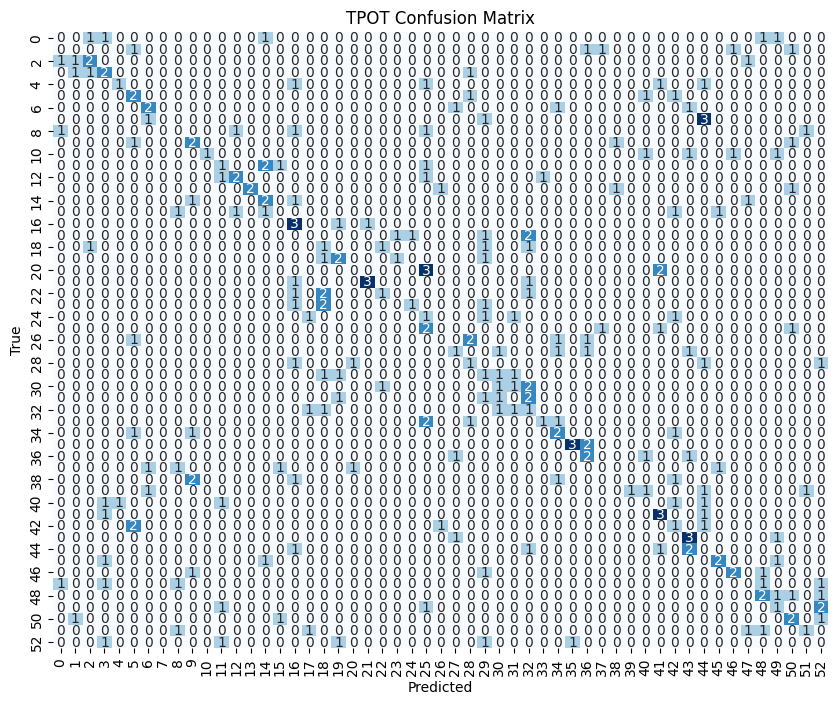

In [48]:
from sklearn.metrics import confusion_matrix

y_pred_tpot = tpot.predict(X_test)
test_acc_tpot = np.mean(y_pred_tpot == y_test)
print(f"TPOT Accuracy: {test_acc_tpot * 100:.2f}%")

conf_matrix_tpot = confusion_matrix(y_test, y_pred_tpot)

# Plot confusion matrix for TPOT with label name on label dict
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_tpot, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('TPOT Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# ts_length = len(test_df)
# test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
# test_steps = ts_length // test_batch_size
# train_score = model.evaluate(train_generator, steps= test_steps, verbose= 1)
# valid_score = model.evaluate(valid_generator, steps= test_steps, verbose= 1)
# test_score = model.evaluate(test_generator, steps= test_steps, verbose= 1)

# print("Train Loss: ", train_score[0])
# print("Train Accuracy: ", train_score[1])
# print('-' * 20)
# print("Validation Loss: ", valid_score[0])
# print("Validation Accuracy: ", valid_score[1])
# print('-' * 20)
# print("Test Loss: ", test_score[0])
# print("Test Accuracy: ", test_score[1])

In [ ]:
# y_true=test_generator.labels
# y_pred= []
# preds=model.predict(test_generator, verbose=1)
# classes=list(test_generator.class_indices.keys())
# class_count=len(classes)
# for i, p in enumerate(preds):
#     pred_index=np.argmax(p)
#     true_index=test_generator.labels[i]
#     y_pred.append(pred_index)

# cm = confusion_matrix(y_true, y_pred)
# plt.figure(figsize=(18, 11))
# sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
# plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
# plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("Confusion Matrix")
# plt.show()

# clr = classification_report(y_true, y_pred, target_names=classes, digits= 4)
# print("Classification Report:\n----------------------\n", clr)

In [ ]:
# one_img = cv2.imread('/content/test/five of clubs/1.jpg')
# label = list(train_generator.class_indices.keys())
# plt.imshow(one_img)
# plt.show()
# one_img = one_img/255
# one_img = np.expand_dims(one_img, 0)
# one_pred = model.predict(one_img)
# one_pred = np.argmax(one_pred)
# print("Predicted label:",label[one_pred])

## Save model

In [ ]:
# class_dict = train_generator.class_indices
# height = []
# width = []
# for _ in range(len(class_dict)):
#     height.append(img_size[0])
#     width.append(img_size[1])

# Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
# Class_series = pd.Series(list(class_dict.keys()), name= 'class')
# Height_series = pd.Series(height, name= 'height')
# Width_series = pd.Series(width, name= 'width')
# class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
# subject = 'Cards-Classification'
# csv_name = f'{subject}-class_dict.csv'
# csv_save_loc = os.path.join('/content/drive/MyDrive/Dataset/Card-classification/', csv_name)
# class_df.to_csv(csv_save_loc, index= False)
# print(f'class csv file was saved as {csv_save_loc}')

In [ ]:
# loss, accuracy = model.evaluate(test_generator)
# name = f"CardClassification-MobileNet-(224x224)-{(accuracy*100):.2f}.h5"
# model.save(f'/content/drive/MyDrive/Dataset/Card-classification/{name}')
# print(f"Model saved as {name} in /content/drive/MyDrive/Dataset/Card-classification")